##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.5)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths/Fields

In [2]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/hl4_plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [3]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label", "go_no_go_63x", "image_series_63x_qc", "Genes.Detected.CPM"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "Normalized marker sum",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score",
              "go_no_go_63x": "Morpho call(63x)",
              "image_series_63x_qc": "Imaging status",
              "Genes.Detected.CPM": "Genes detected"}

#Replacing string in specific columns
nms_dict = {True: "Pass", False: "Fail"}
morpho_dict = {"63x go": "Go", "63x no go": "No Go"}
imaging_dict = {"ready_for_dendrite_trace": "Ready for dendrite trace", "image_qc_passed": "Image QC passed", 
                "qc": "QC", "deferred": "Deferred", "autotracing": "Autotracing", "rescanning": "Rescanning",
                "processing": "Processing", "failed": "Failed"}

##### Filtering shiny

In [4]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [5]:
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace(nms_dict)
shiny_human["Morpho call(63x)"] = shiny_human["Morpho call(63x)"].replace(morpho_dict)
shiny_human["Imaging status"] = shiny_human["Imaging status"].replace(imaging_dict)
shiny_human["cDNA quality (%>400 bp)"] = shiny_human["cDNA quality (%>400 bp)"] * 100

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [6]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

##### Filtering ephys

In [7]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", 
                      "ri": "Input Resistance(MΩ)",
                      "sag" : "Sag Fraction", 
                      "tau": "τ(s)",
                      "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", 
                      "latency" : "Latency",
                      "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [8]:
ephys

,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
0,H19.03.306.11.15.02.06,-65.122929,185.124964,0.102990,24.413168,3.786294,0.05140,0.165000
1,H18.06.004.11.02.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H18.06.004.11.02.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H18.06.004.11.03.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H19.06.351.11.15.02.01,-60.251895,561.418355,0.015036,37.969562,3.603331,0.03658,0.352966
...,...,...,...,...,...,...,...,...
1444,H20.06.351.11.06.01.04,-65.023605,242.256120,0.161407,23.458603,2.394247,0.02470,0.323529
1445,H20.06.351.11.06.01.05,-65.133683,246.923044,0.077304,21.062437,2.962435,0.02796,0.310000
1446,H20.06.351.11.06.01.06,-69.985204,311.142892,0.071834,23.771703,2.533110,0.02944,0.375000
1447,H20.06.351.11.06.01.08,-61.401253,309.951991,0.213605,17.061975,2.534424,0.02004,0.425000


##### h_l4

In [9]:
h_l4 = filter_df(shiny_human, "layer", "L4")

INFO:temp_funcs:Filtered dataframe based on layer == L4


##### tcx

In [10]:
fcx = filter_df(h_l4, "region", "FCx") #375 rows
fcx = filter_df(fcx, "NMS Pass/Fail", "Pass") #307 rows

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass


In [11]:
fcx.count()

sample_id                  54
cell_name                  54
roi                        54
cDNA quality (%>400 bp)    54
RNA Amp Pass/Fail          54
Amplified content (ng)     54
Genes detected             54
cell_specimen_project      53
Morpho call(63x)           43
Imaging status             19
Normalized marker sum      54
NMS Pass/Fail              54
seurat_cluster_label       54
Seurat prediction score    54
broad_class_label          54
subclass_label             54
Tree_call                  54
region                     54
layer                      54
dtype: int64

##### Merged tcx with ephys

In [12]:
merged = merge_dataframes(fcx, ephys, "cell_name", "name", "inner") #269 rows
merged.dropna(subset=ephys_list, inplace=True) #244 rows
merged.sort_values(by="seurat_cluster_label", inplace=True)

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [13]:
merged.count()

sample_id                  27
cell_name                  27
roi                        27
cDNA quality (%>400 bp)    27
RNA Amp Pass/Fail          27
Amplified content (ng)     27
Genes detected             27
cell_specimen_project      27
Morpho call(63x)           25
Imaging status             14
Normalized marker sum      27
NMS Pass/Fail              27
seurat_cluster_label       27
Seurat prediction score    27
broad_class_label          27
subclass_label             27
Tree_call                  27
region                     27
layer                      27
name                       27
Vm(mV)                     27
Input Resistance(MΩ)       27
Sag Fraction               27
τ(s)                       27
LS AP up/downstoke         27
Latency                    27
F-I Curve                  27
dtype: int64

##### Seurat list with greater than 5 datapoints

In [14]:
seurat_list =[]
for n in merged["seurat_cluster_label"].unique():
        value = merged[merged["seurat_cluster_label"] == n]["Vm(mV)"].count() >= 5
        if value == True:
            seurat_list.append(n)
seurat_sorted_list = sorted(seurat_list)
seurat_sorted_list

['Exc L3-5 RORB ESR1']

In [15]:
subclass_list =[]
for n in merged["subclass_label"].unique():
        value = merged[merged["subclass_label"] == n]["Vm(mV)"].count() >= 5
        if value == True:
            subclass_list.append(n)
subclass_sorted_list = sorted(subclass_list)
subclass_sorted_list

['IT (L3-5)', 'IT (L4-6)', 'PVALB']

##### Plot Colors

In [16]:
ei_seurat_colors=["#67000d", "#a50f15", "#cb181d", "#ef3b2c", "#fb6a4a", "#fc9272", "#fcbba1", "#fee0d2", 
                  "#3182bd", "#9ecae1"]
ei_subclass_colors=["#cb181d", "#fb6a4a", "#fcae91",
                    "#2171b5", "#6baed6", "#bdd7e7"]
gn_colors={"Go": "#41ab5d", "No Go": "#ef3b2c"}
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

##### Clustered Boxplot for TCx

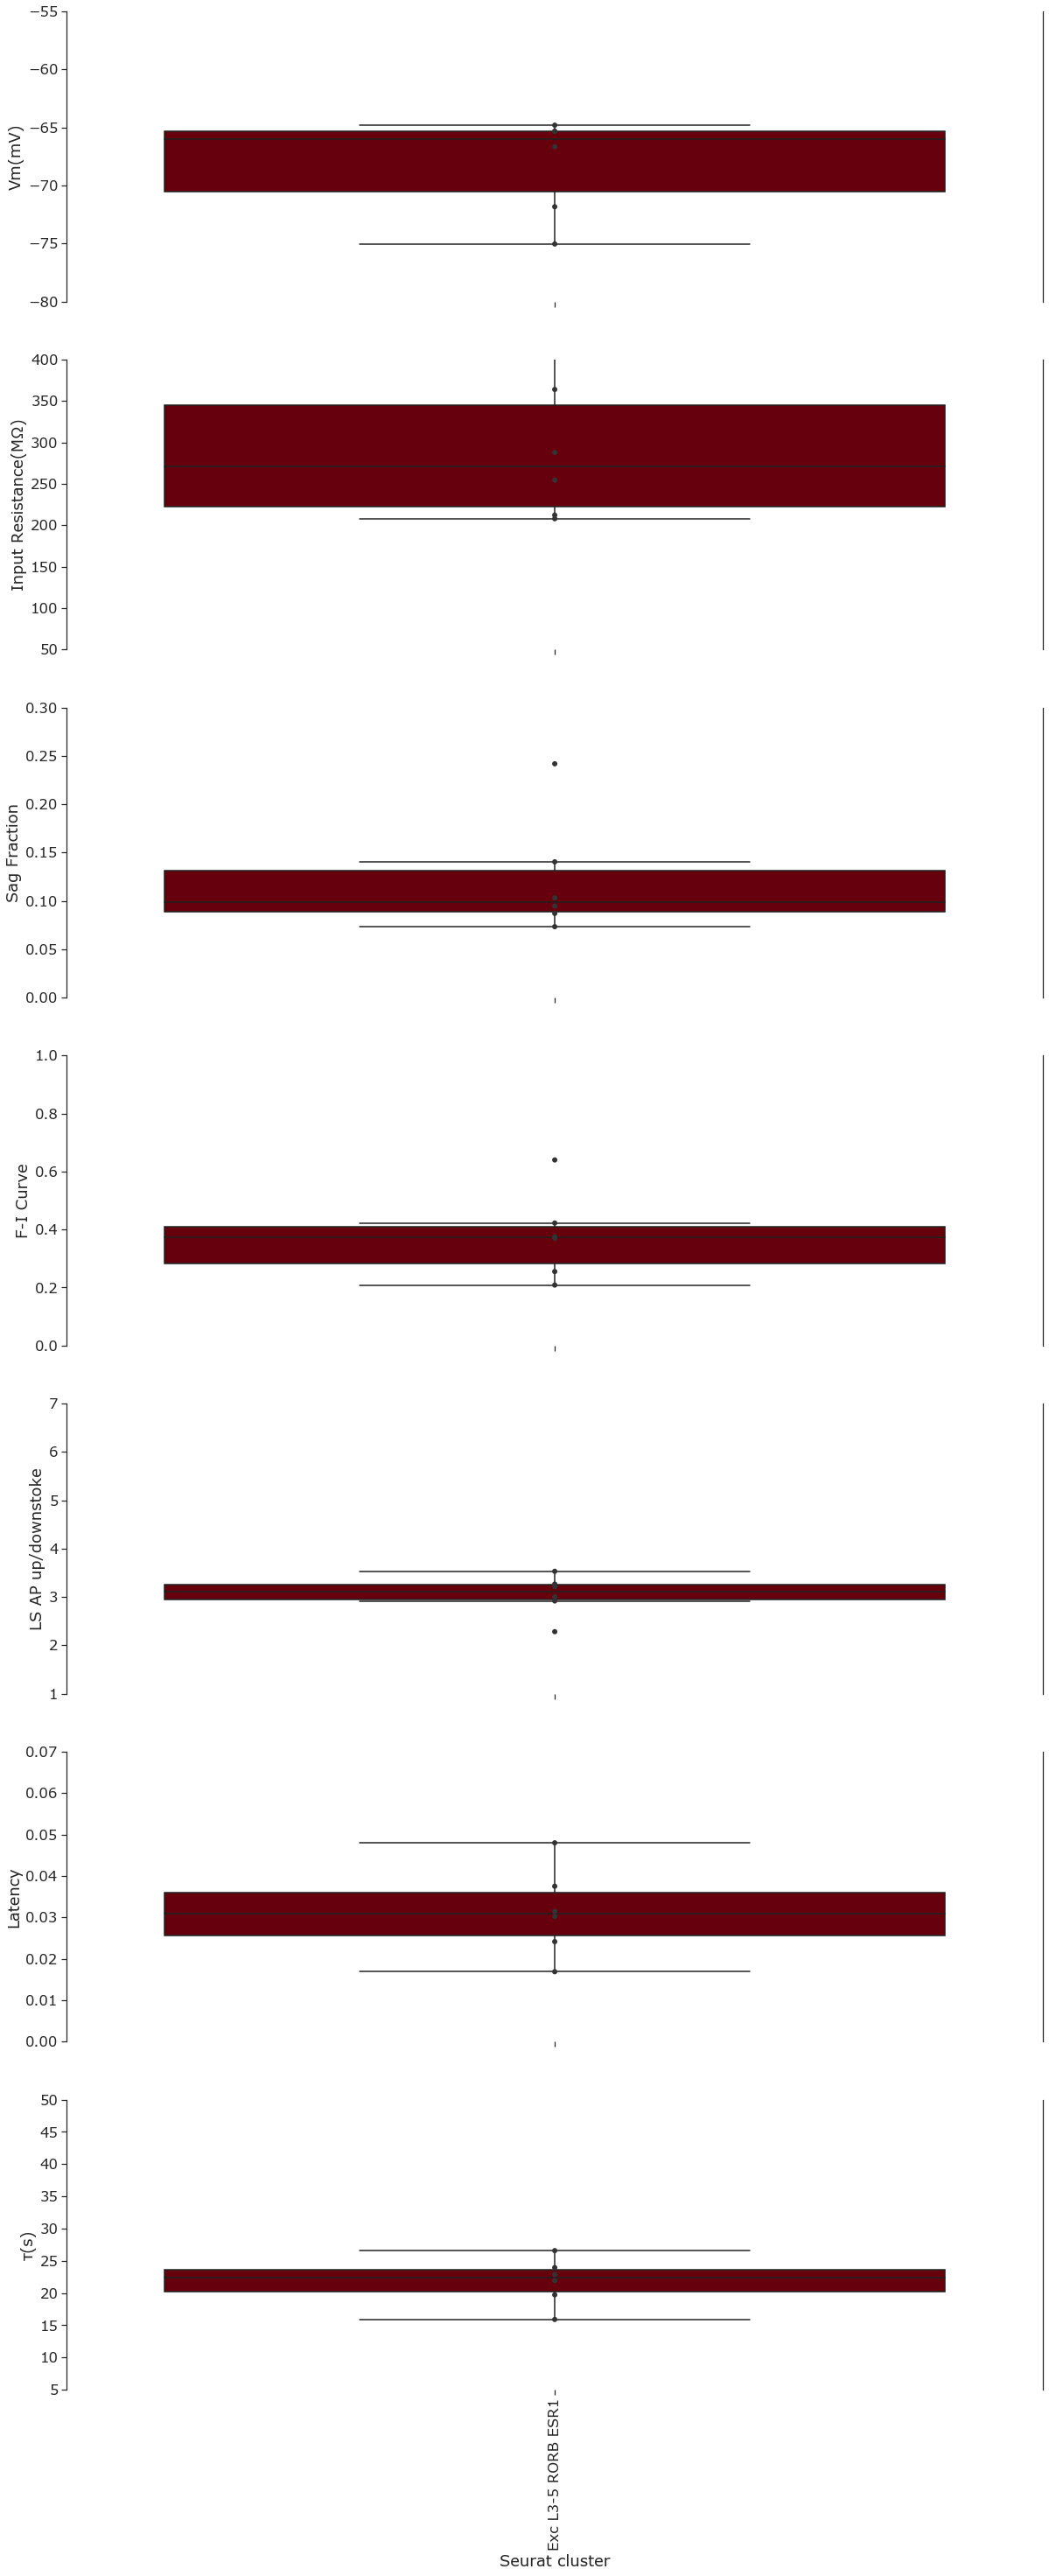

In [17]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))

ax = sns.boxplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list, 
                 showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[0])
ax = sns.stripplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list,
                   color="0.2", size=6, jitter=False, ax=axes[0])

ax1 = sns.boxplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list, 
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[1])
ax1 = sns.stripplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[1])

ax2 = sns.boxplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[2])
ax2 = sns.stripplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[2])

ax3 = sns.boxplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[3])
ax3 = sns.stripplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[3])

ax4 = sns.boxplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[4])
ax4 = sns.stripplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[4])

ax5 = sns.boxplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list, 
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[5])
ax5 = sns.stripplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[5])

ax6 = sns.boxplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list,
                  showfliers=False, palette=ei_seurat_colors, saturation=1, ax=axes[6])
ax6 = sns.stripplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[6])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Seurat cluster")
sns.despine(bottom=True, right=False)

ax.set(ylim=(-80, -55))
ax1.set(ylim=(50, 400))
ax2.set(ylim=(0, 0.3))
ax3.set(ylim=(0, 1))
ax4.set(ylim=(1, 7))
ax5.set(ylim=(0, 0.07))
ax6.set(ylim=(5, 50))

plt.xticks(rotation=90)
plt.savefig(plot_path + "tcx_seurat_bxplot.jpeg", bbox_inches="tight")

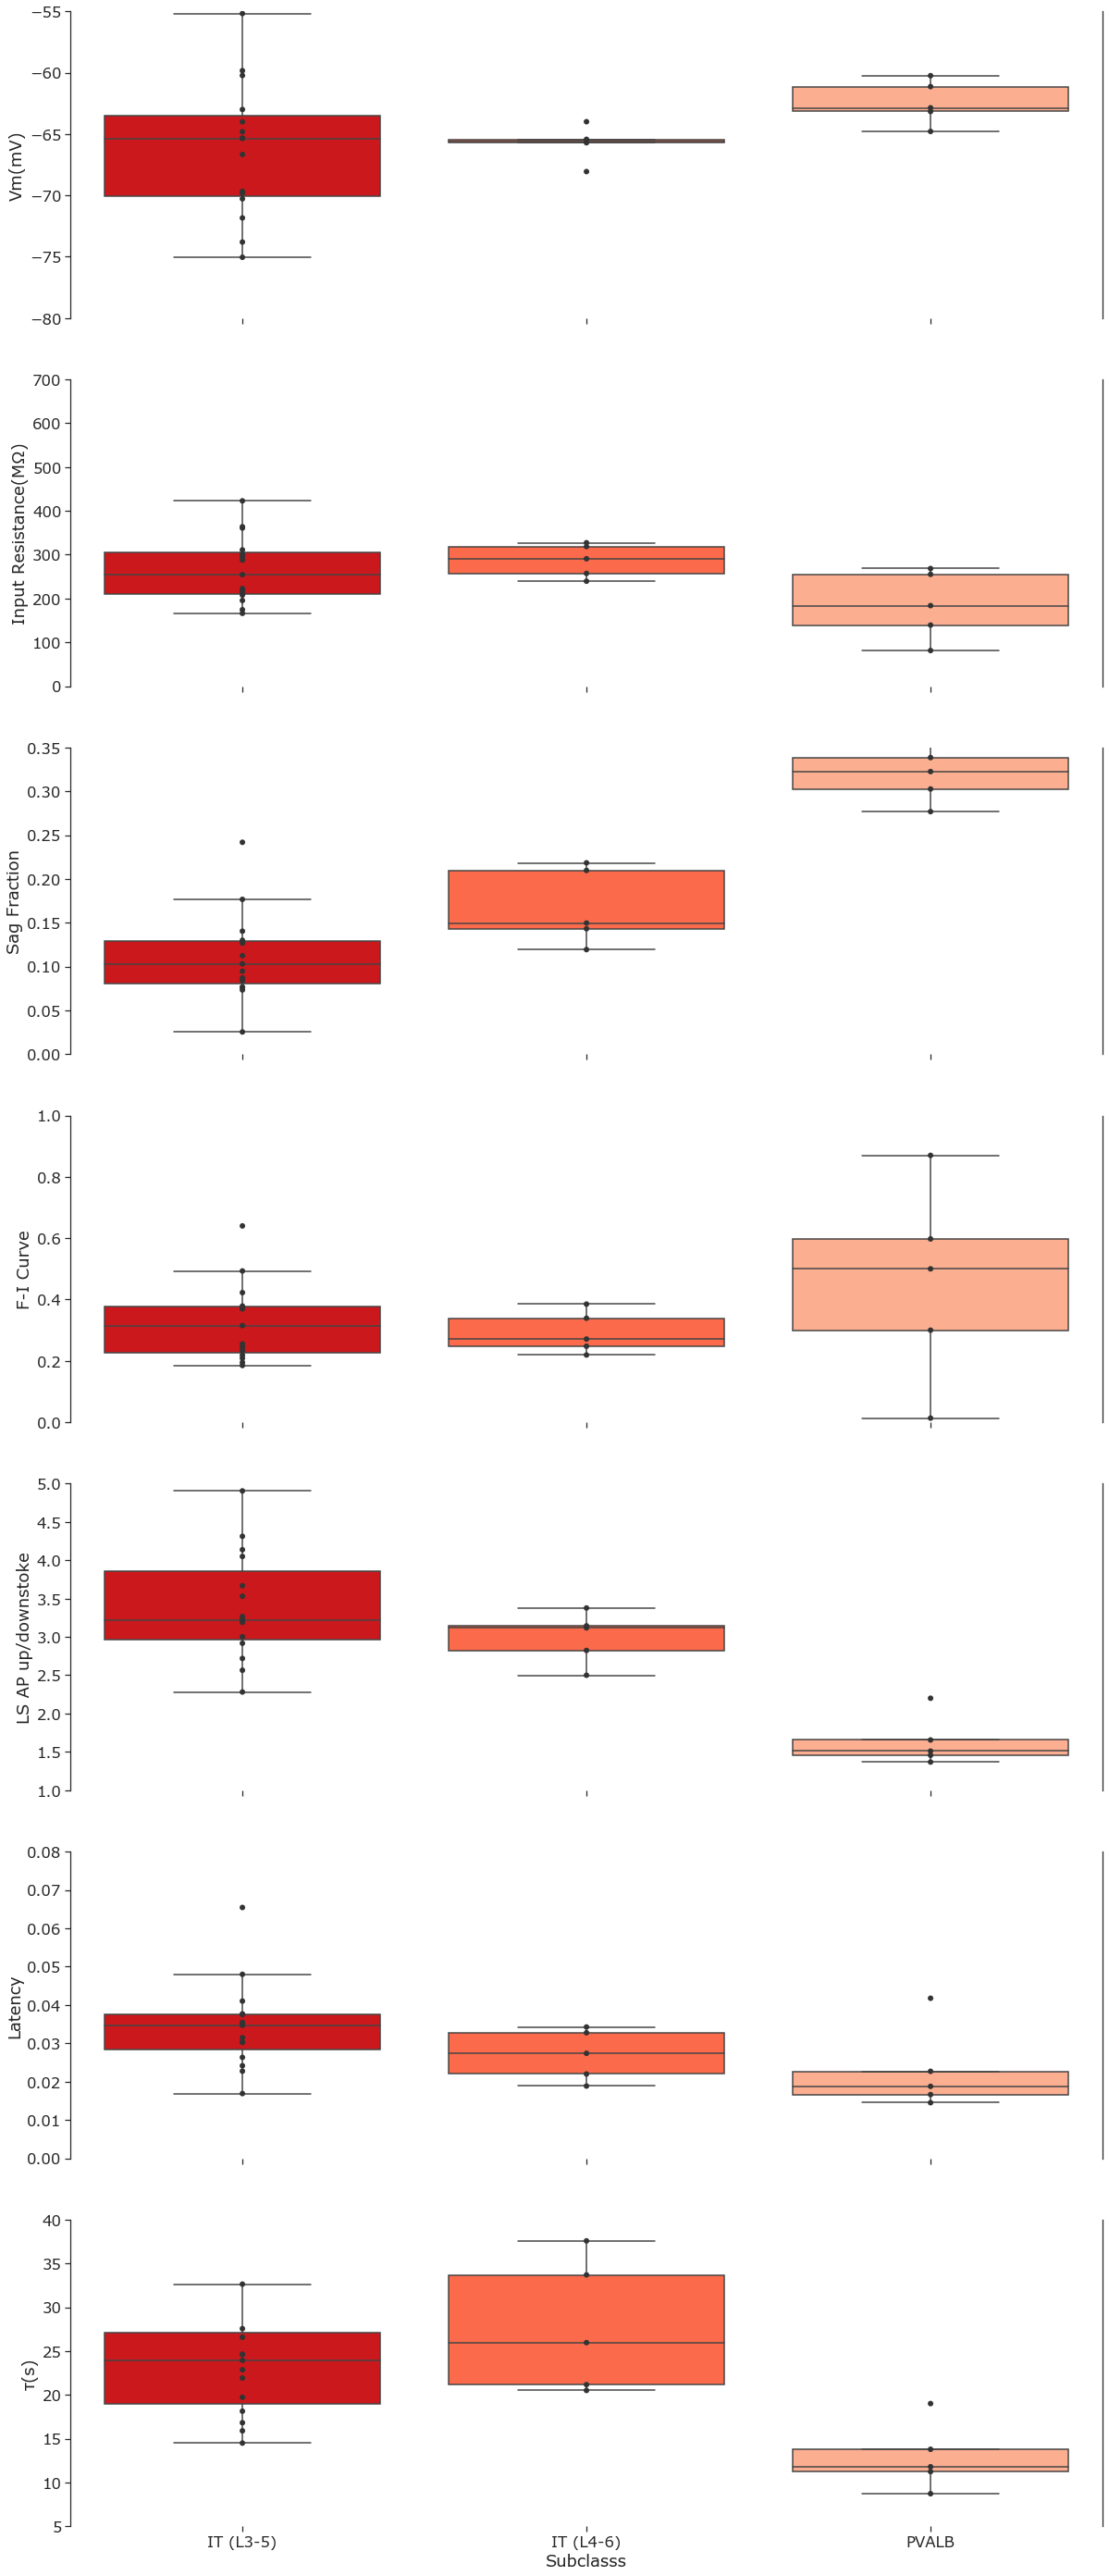

In [18]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 50))

ax = sns.boxplot(x="subclass_label", y="Vm(mV)", data=merged, order=subclass_sorted_list, 
                 showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[0])
ax = sns.stripplot(x="subclass_label", y="Vm(mV)", data=merged, order=subclass_sorted_list,
                   color="0.2", size=6, jitter=False, ax=axes[0])

ax1 = sns.boxplot(x="subclass_label", y="Input Resistance(MΩ)", data=merged, order=subclass_sorted_list, 
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[1])
ax1 = sns.stripplot(x="subclass_label", y="Input Resistance(MΩ)", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[1])

ax2 = sns.boxplot(x="subclass_label", y="Sag Fraction", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[2])
ax2 = sns.stripplot(x="subclass_label", y="Sag Fraction", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[2])

ax3 = sns.boxplot(x="subclass_label", y="F-I Curve", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[3])
ax3 = sns.stripplot(x="subclass_label", y="F-I Curve", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[3])

ax4 = sns.boxplot(x="subclass_label", y="LS AP up/downstoke", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[4])
ax4 = sns.stripplot(x="subclass_label", y="LS AP up/downstoke", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[4])

ax5 = sns.boxplot(x="subclass_label", y="Latency", data=merged, order=subclass_sorted_list, 
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[5])
ax5 = sns.stripplot(x="subclass_label", y="Latency", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[5])

ax6 = sns.boxplot(x="subclass_label", y="τ(s)", data=merged, order=subclass_sorted_list,
                  showfliers=False, palette=ei_subclass_colors, saturation=1, ax=axes[6])
ax6 = sns.stripplot(x="subclass_label", y="τ(s)", data=merged, order=subclass_sorted_list,
                    color="0.2", size=6, jitter=False, ax=axes[6])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclasss")
sns.despine(bottom=True, right=False)

ax.set(ylim=(-80, -55))
ax1.set(ylim=(0, 700))
ax2.set(ylim=(0, 0.35))
ax3.set(ylim=(0, 1))
ax4.set(ylim=(1, 5))
ax5.set(ylim=(0, 0.08))
ax6.set(ylim=(5, 40))

plt.xticks(rotation=0)
plt.savefig(plot_path + "tcx_subclass_bxplot.jpeg", bbox_inches="tight")

(array([0]), <a list of 1 Text xticklabel objects>)

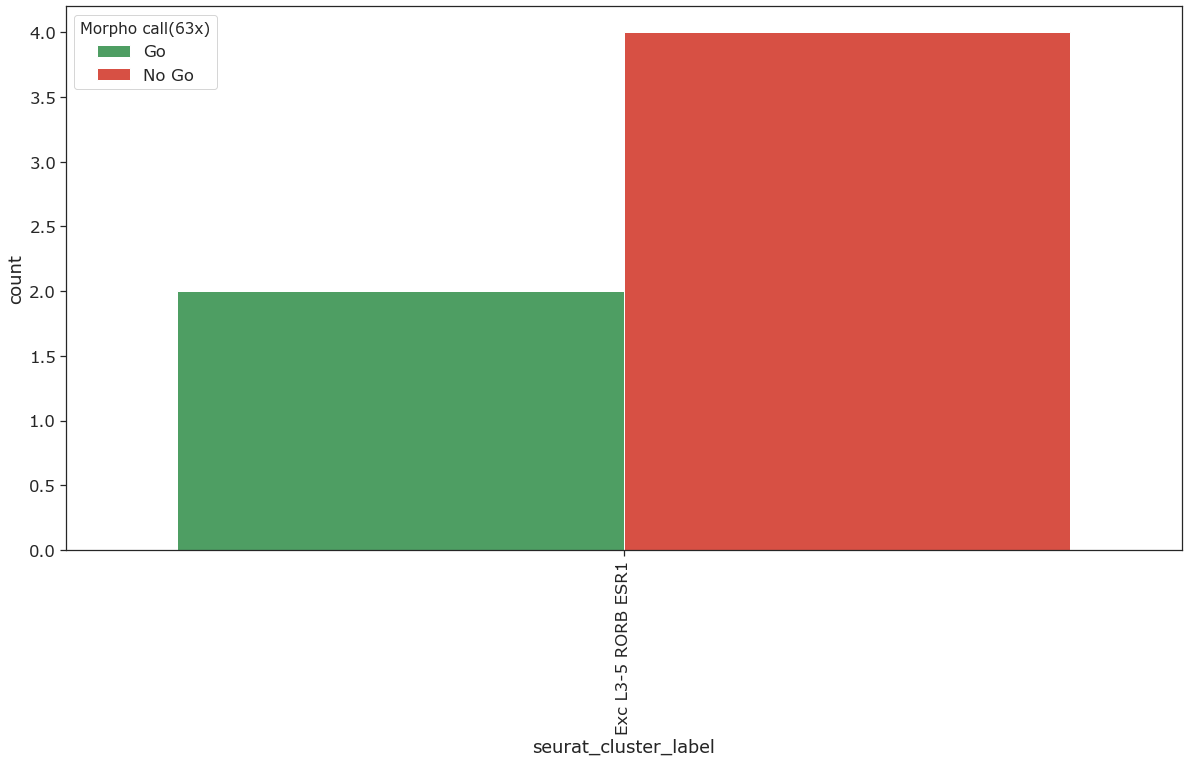

In [19]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="Morpho call(63x)", data=merged,
              palette=gn_colors)
plt.xticks(rotation=90)

In [20]:
imaging_status_list = ["Deferred", "Ready for dendrite trace", "QC", "Image QC passed", "Autotracing", 
                       "Rescanning", "Processing", "Failed"]

(array([0]), <a list of 1 Text xticklabel objects>)

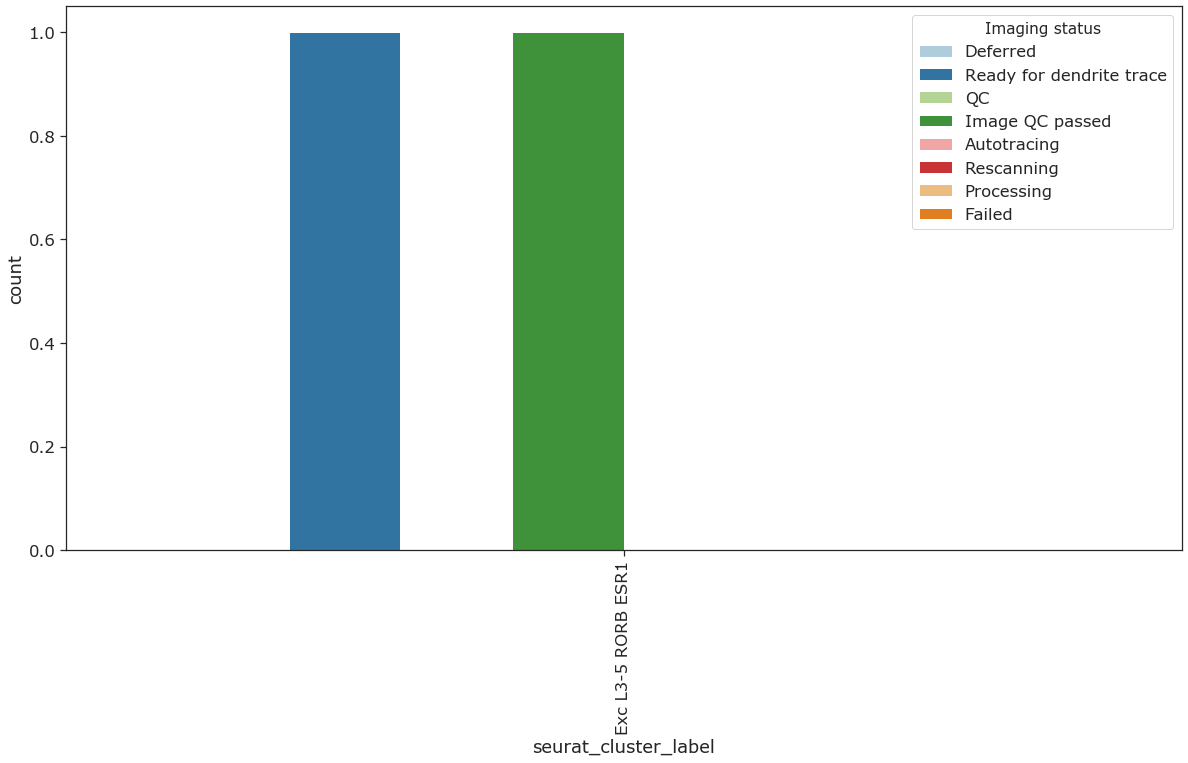

In [21]:
f, axes = plt.subplots(figsize=(20, 10))
sns.countplot(x="seurat_cluster_label", order=seurat_sorted_list, hue="Imaging status", hue_order=imaging_status_list,
              data=merged, palette="Paired")
plt.xticks(rotation=90)

In [22]:
merged

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),Genes detected,cell_specimen_project,Morpho call(63x),Imaging status,Normalized marker sum,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
16,PES4_190419_655_A01,H19.03.309.11.11.01.03,FCx_L4,65.7,Pass,27.926194,11001,hIVSCC-MET,Go,Deferred,0.704652,Pass,Exc L3-5 RORB COL22A1,0.997444,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.309.11.11.01.03,-73.803561,360.787302,0.025340,47.465407,4.311797,0.04100,0.195000
17,P8S4_190419_355_A01,H19.03.309.11.08.02.02,FCx_L4,71.8,Pass,31.777549,12124,hIVSCC-MET,No Go,NaN,0.981459,Pass,Exc L3-5 RORB COL22A1,1.000000,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.309.11.08.02.02,-60.225854,300.770789,0.076595,42.861043,4.049080,0.03544,0.244860
15,PAS4_190514_458_A01,H19.03.312.11.01.01.03,FCx_L4,62.2,Pass,19.826293,12542,hIVSCC-MET,No Go,NaN,0.940950,Pass,Exc L3-5 RORB COL22A1,0.666350,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.312.11.01.01.03,-59.833433,295.165390,0.127975,24.633506,4.137119,0.03032,0.493103
8,P1S4_190425_005_A01,H19.03.310.11.05.01.06,FCx_L4,64.3,Pass,10.687584,8602,hIVSCC-MET,Go,Ready for dendrite trace,0.905431,Pass,Exc L3-5 RORB ESR1,0.902672,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.310.11.05.01.06,-65.324047,207.812577,0.140336,19.722653,3.002196,0.03022,0.375000
9,P8S4_190425_354_A01,H19.03.310.11.06.02.03,FCx_L4,54.0,Pass,13.492552,10276,hIVSCC-MET,No Go,NaN,0.805975,Pass,Exc L3-5 RORB ESR1,0.708869,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.310.11.06.02.03,-65.357080,287.821680,0.094616,26.572790,3.265239,0.03146,0.422500
10,PAS4_190425_456_A01,H19.03.310.11.04.01.05,FCx_L4,56.8,Pass,10.693818,9537,hIVSCC-MET,No Go,NaN,0.933963,Pass,Exc L3-5 RORB ESR1,0.607304,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.310.11.04.01.05,-75.044196,212.093741,0.073279,21.923690,3.212367,0.04798,0.255172
11,P8S4_190425_356_A01,H19.03.310.11.06.02.05,FCx_L4,63.2,Pass,13.295977,8837,hIVSCC-MET,No Go,NaN,0.905721,Pass,Exc L3-5 RORB ESR1,0.991489,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.310.11.06.02.05,-64.805659,422.812462,0.241781,23.938928,2.917022,0.02414,0.370000
13,P2S4_190514_054_A01,H19.03.312.11.05.01.03,FCx_L4,60.4,Pass,23.957173,12726,hIVSCC-MET,No Go,NaN,0.863310,Pass,Exc L3-5 RORB ESR1,0.951914,Glutamatergic neuron,IT (L3-5),Core,FCx,L4,H19.03.312.11.05.01.03,-66.663722,363.793105,0.087010,15.895891,2.281154,0.01688,0.640000
14,PES4_190425_654_A01,H19.03.310.11.06.01.04,FCx_L4,56.1,Pass,18.525937,10289,hIVSCC-MET,Go,Image QC passed,0.820059,Pass,Exc L3-5 RORB ESR1,1.000000,Glutamatergic neuron,IT (L3-5),I1,FCx,L4,H19.03.310.11.06.01.04,-71.835605,254.437447,0.103056,22.860612,3.530150,0.03750,0.208621
22,PFS4_190419_704_A01,H19.03.309.11.10.01.04,FCx_L4,71.1,Pass,34.136612,12611,hIVSCC-MET,No Go,NaN,0.972368,Pass,Exc L3-5 RORB FILIP1L,0.459979,Glutamatergic neuron,IT (L3-5),I2,FCx,L4,H19.03.309.11.10.01.04,-70.277098,166.062430,0.176642,24.616710,3.667383,0.03766,0.218644


##### Tree call Plots

[(50, 80)]

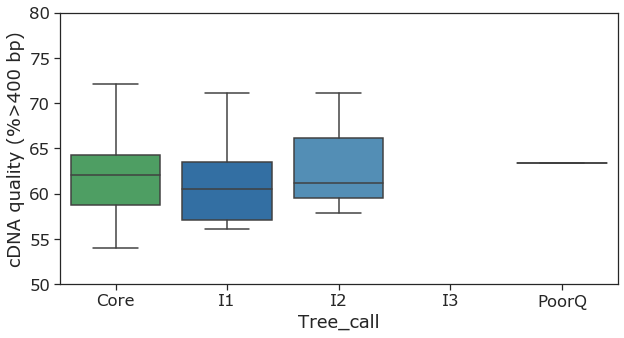

In [29]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="cDNA quality (%>400 bp)", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(50, 80))

[(6000, 15000)]

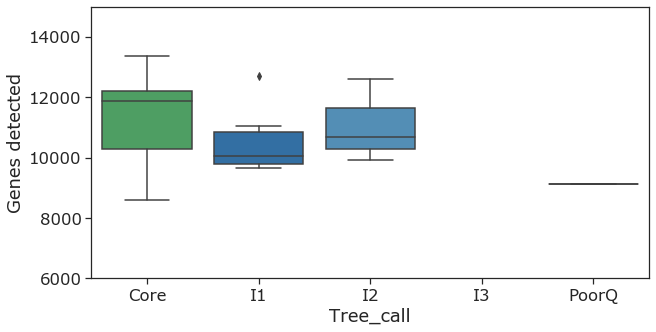

In [30]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Genes detected", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(6000,15000))

[(0, 45)]

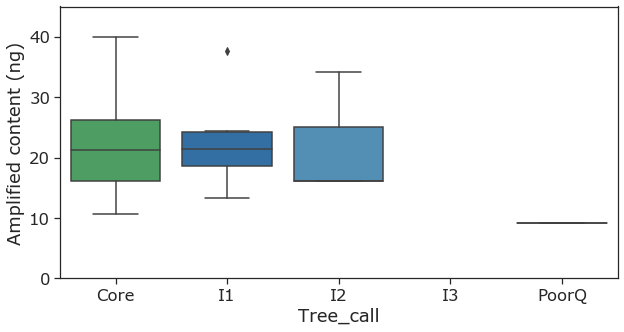

In [25]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Amplified content (ng)", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(0, 45))

[(0.4, 1.3)]

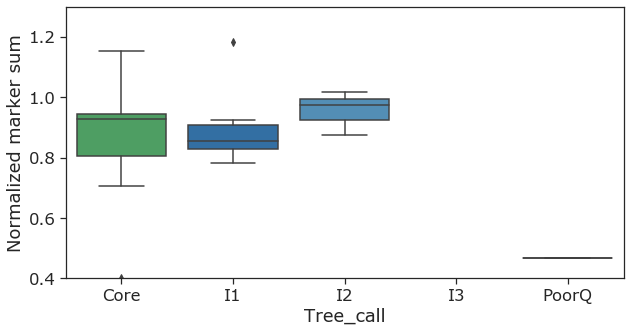

In [26]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Normalized marker sum", data=merged, palette=tree_colors, order=tree_colors)
ax.set(ylim=(0.4, 1.3))

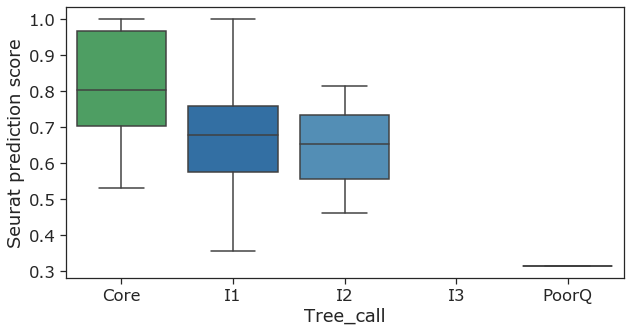

In [27]:
f, axes = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x="Tree_call", y="Seurat prediction score", data=merged, palette=tree_colors, order=tree_colors)